# Simple Bézier Interpolation
Reference: https://towardsdatascience.com/b%C3%A9zier-interpolation-8033e9a262c2


In [345]:
#Pkg.add("Pkg"); import Pkg; 
using Pkg
using Distributed
using DelimitedFiles
using Distances
using StatsBase 
using Profile    
using Random
using Statistics
using LinearAlgebra
using Distributions
using Plots
#using StatsPlots
using Printf
rng = Random.MersenneTwister(1234);

In [346]:
include("src/Bezier_interpolation.jl")

get_bezier_interpolation_periodic

In [347]:
N = 50; # number of data point
x_set = [ rand()+n for n in 1:(N+1)]; # observed time point
p_set = sin.(pi * 6 * (1.0/N)*x_set) + 0.1*randn(size(x_set)); # observed value at each  

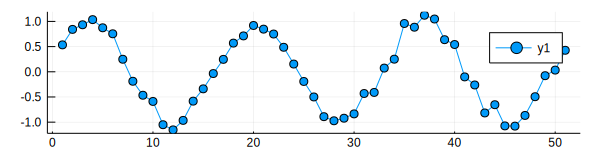

In [348]:
# For check
Plots.plot(p_set, marker=:circle, size=(600,150))

In [349]:
# get interpolation point btw (t,t+dt) for each t
(a_vec, b_vec) = get_a_b_Bezier(N,p_set);

In [350]:
p_set_left = p_set[1:N]
p_set_right = p_set[2:(N+1)];

In [351]:
# Drawing Bézier curve
t= 0.5
n=1
n_grid = 100; grid_scale=1.0/n_grid
Bez_curve = Bez.(collect(0:n_grid)*grid_scale, p_set_left[n], p_set_right[n], a_vec[n], b_vec[n])
for n in 2:N
    Bez_curve = vcat(Bez_curve, Bez.(collect(0:n_grid)*grid_scale, p_set_left[n], p_set_right[n], a_vec[n], b_vec[n]))
end;

In [352]:
#For visiualization
xAxis = [1+i*grid_scale for i in 0:n_grid]
for n in 2:(N)
    xAxis = vcat(xAxis, [1+(n-1)+ i*grid_scale for i in 0:n_grid])
end;    

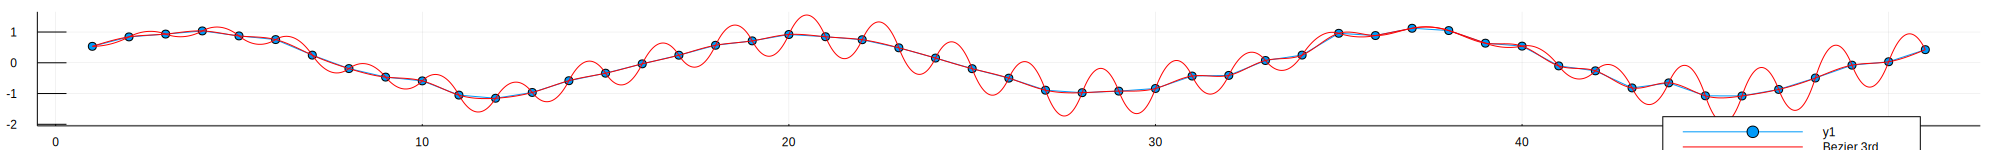

In [379]:
# For check. Note, the Bezier curve through the given data point exactly, so it can be sensitive against underlying data noise.
#Plots.plot(p_set, marker=:circle, size=(600,150))
Plots.plot(p_set, marker=:circle, size=(600,150))
Plots.plot!(xAxis, Bez_curve, size=(2000,150), color="red", label="Bezier 3rd")
Plots.plot!(xAxis, Bez_curve_2nd, size=(2000,150), color="red", label="Bezier 2nd")


In [340]:
Bez_2nd(t, p1, p2, a) = (1-t)^2 * p1 + 2*t*(1-t)*a + t^2 * p2;

In [375]:
function get_a_Bezier_2ndOrder(p_set)
    N = size(p_set,1)-1
    avec = zeros(N)
    avec[1] = p_set[1]
    for n in 2:N
        avec[n] = 2*p_set[n]-avec[n-1]
    end
    return avec
end;

In [376]:
(a_vec_2nd) = get_a_Bezier_2ndOrder(p_set);

In [377]:
# Drawing Bézier curve
t= 0.5
n=1
n_grid = 100; grid_scale=1.0/n_grid
Bez_curve_2nd = Bez_2nd.(collect(0:n_grid)*grid_scale, p_set_left[n], p_set_right[n], a_vec_2nd[n])
for n in 2:N
    Bez_curve_2nd = vcat(Bez_curve_2nd, Bez_2nd.(collect(0:n_grid)*grid_scale, p_set_left[n], p_set_right[n], a_vec_2nd[n]) )
end;

# Mean Square Error between the Bézier regressin and the original line.

In [184]:
max_x =Int(floor( maximum(x_set) ))
n_interpolation = 10; scale_interpolation = 1.0/n_interpolation
x_set_true = collect(1:max_x*n_interpolation)*scale_interpolation
p_set_true = sin.(pi * 6 * (1.0/N)*x_set_true);

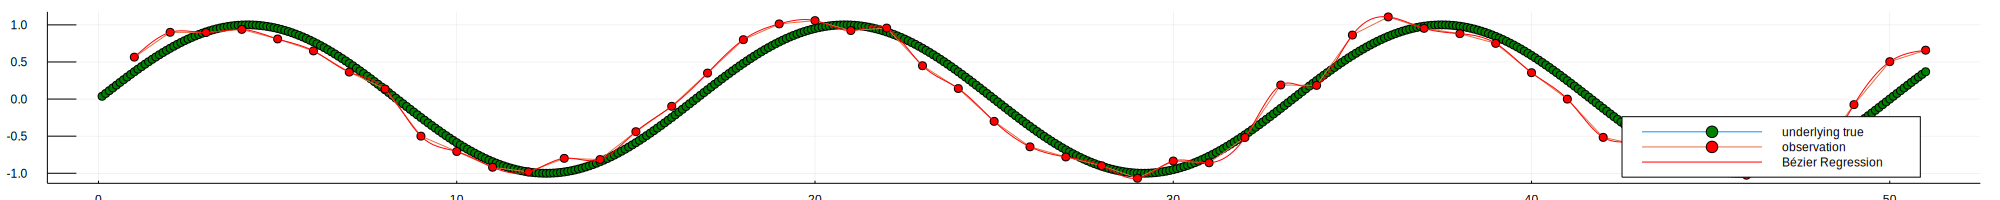

In [185]:
# For check. Note, the Bezier curve through the given data point exactly, so it can be sensitive against underlying data noise.
#Plots.plot(p_set, marker=:circle, size=(600,150))
Plots.plot(x_set_true, p_set_true, marker=:circle, markercolor="green", label="underlying true")
Plots.plot!(p_set, marker=:circle, markercolor="red", label="observation")
Plots.plot!(xAxis, Bez_curve, size=(2000,200), color="red", label="Bézier Regression")


In [231]:
# this function returs a naive interpolation using n_interpolation points between each time interval --> should 
function get_bezier_interpolation(x_set, p_set_left, p_set_right, a_vec, b_vec)
    n_interpolation = 10; scale_interpolation = 1.0/n_interpolation
    
    x_axis = x_set[1] .+ (x_set[2]-x_set[1])*scale_interpolation*collect(0:(n_interpolation-1))
    y_axis = Bez.(scale_interpolation*collect(0:(n_interpolation-1)), p_set_left[1], p_set_right[1], a_vec[1], b_vec[1]);
    for n in 1:49
        x_axis = vcat(x_axis, x_set[n+1] .+ (x_set[n+2]-x_set[n+1]) * scale_interpolation*collect(0:(n_interpolation-1)))
        y_axis = vcat(y_axis, Bez.(scale_interpolation*collect(0:(n_interpolation-1)), p_set_left[n+1], p_set_right[n+1], a_vec[n+1], b_vec[n+1]))
    end
    return(x_axis, y_axis)
end

get_bezier_curve (generic function with 1 method)

In [187]:
@show Bez_out = Bez.(scale_interpolation*collect(0:(n_interpolation-1)), p_set_left[n], p_set_right[n], a_vec[n], b_vec[n]);;

Bez_out = Bez.(scale_interpolation * collect(0:n_interpolation - 1), p_set_left[n], p_set_right[n], a_vec[n], b_vec[n]) = [0.565166, 0.608262, 0.650776, 0.692124, 0.731723, 0.768991, 0.803344, 0.834199, 0.860973, 0.883084]


In [232]:
(x_axis, y_axis) = get_bezier_interpolation(x_set, p_set_left, p_set_right, a_vec, b_vec);

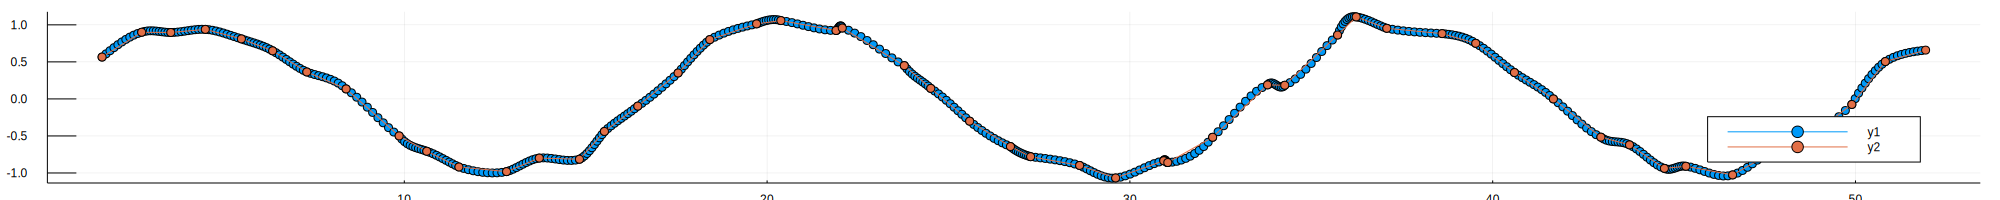

In [233]:
Plots.plot(x_axis, y_axis, marker=:circle)
Plots.plot!(x_set, p_set, marker=:circle, size=(2000,200))

In [290]:
# suppose the observation points are periodics
N = 50; # number of data point
n_out = 5
x_set = [ n*n_out for n in 1:(N+1)]; # observed time point
p_set = sin.(pi * (1.0/N)*x_set) + 0.1*randn(size(x_set)); # observed value at each  

In [291]:
# get interpolation point btw (t,t+dt) for each t
(a_vec, b_vec) = get_a_b_Bezier(N,p_set);
p_set_left = p_set[1:N]
p_set_right = p_set[2:(N+1)];

In [255]:
# Drawing Bézier curve
"""
t= 0.5
n=1
n_grid = 10; grid_scale=1.0/n_grid
x_axis
Bez_curve = Bez.(collect(0:n_grid)*grid_scale, p_set_left[n], p_set_right[n], a_vec[n], b_vec[n])
for n in 2:N
    Bez_curve = vcat(Bez_curve, Bez.(collect(0:n_grid)*grid_scale, p_set_left[n], p_set_right[n], a_vec[n], b_vec[n]))
end;
"""

In [256]:
"""
#For visiualization
xAxis = [1+i*grid_scale for i in 0:n_grid]
for n in 2:(N)
    xAxis = vcat(xAxis, [1+(n-1)+ i*grid_scale for i in 0:n_grid])
end;    
"""

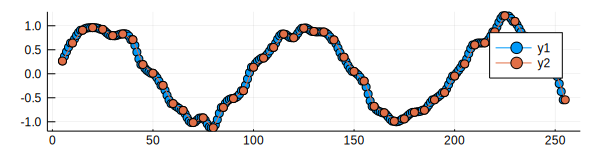

In [316]:
# For check. Note, the Bezier curve through the given data point exactly, so it can be sensitive against underlying data noise.
#Plots.plot(p_set, marker=:circle, size=(600,150))
Plots.plot(x_axis, y_axis, marker=:circle, size=(600,150))
Plots.plot!(x_set, p_set, marker=:circle, size=(600,150))


#Plots.plot!(xAxis, Bez_curve, size=(2000,150), color="red")


In [308]:
# This is the case that the xaxis should be compared is given.
# Let's suppose that the given point is periodic such as [1, 11, 21, 31, ..., max%10]
# Then interpoltion ponts are all intergers should be considers [1, 2, 3, ...., Int(max)]
 # suppos the interval is given.
#n_out = 5
scale_n_out = 1.0 / (n_out-1)
#n_interpolation = 10; scale_interpolation = 1.0/n_interpolation
x_axis = collect(x_set[1]:(x_set[2]-1))
y_axis = Bez.( scale_n_out*collect(0:(n_out-1)), p_set_left[1], p_set_right[1], a_vec[1], b_vec[1]);
for n in 1:(N-1)
   x_axis = vcat(x_axis, collect(x_set[n+1]:(x_set[n+2]-1)) )
    y_axis = vcat(y_axis, Bez.( scale_n_out*collect(0:(n_out-1)), p_set_left[n+1], p_set_right[n+1], a_vec[n+1], b_vec[n+1]))
end

In [314]:
function get_bezier_interpolation_periodic(n_out, x_set, p_set_left, p_set_right, a_vec, b_vec)
    scale_n_out = 1.0 / (n_out-1)
    #n_interpolation = 10; scale_interpolation = 1.0/n_interpolation
    x_axis = collect(x_set[1]:(x_set[2]-1))
    y_axis = Bez.( scale_n_out*collect(0:(n_out-1)), p_set_left[1], p_set_right[1], a_vec[1], b_vec[1]);
    for n in 1:(N-1)
        x_axis = vcat(x_axis, collect(x_set[n+1]:(x_set[n+2]-1)) )
        y_axis = vcat(y_axis, Bez.( scale_n_out*collect(0:(n_out-1)), p_set_left[n+1], p_set_right[n+1], a_vec[n+1], b_vec[n+1]))
    end
    return (x_axis, y_axis)
end

get_bezier_interpolation_periodic (generic function with 1 method)

In [315]:
(x_axis, y_axis) = get_bezier_interpolation_periodic(n_out, x_set, p_set_left, p_set_right, a_vec, b_vec)

([5, 6, 7, 8, 9, 10, 11, 12, 13, 14  …  245, 246, 247, 248, 249, 250, 251, 252, 253, 254], [0.265758, 0.362997, 0.458841, 0.551896, 0.640767, 0.640767, 0.723751, 0.797914, 0.860017, 0.906816  …  0.313985, 0.280001, 0.231456, 0.162571, 0.0675651, 0.0675651, -0.0570484, -0.205587, -0.370075, -0.542539])

In [317]:
P_left = rand(5,5); P_right = rand(5,5); 
a_mat = rand(5,5); b_mat = rand(5,5); 
P_left = P_left + P_left'
P_right = P_right + P_right'
a_mat = a_mat + a_mat'
b_mat = b_mat + b_mat';

In [ ]:
Bez(t, p1, p2, a, b) = (1-t)^3 * p1 + 3 * t * (1-t)^2 * a + 3 * t^2 * (1-t) * b + t^3 * p2; 

In [331]:
r = 0
B_curve = Bez(r, P_left, P_right, a_mat, b_mat)

5×5 Array{Float64,2}:
 1.70993   1.70558   0.384537  1.36969   1.11383 
 1.70558   1.53014   0.2206    0.524673  0.07293 
 0.384537  0.2206    1.931     0.199228  0.622924
 1.36969   0.524673  0.199228  0.231662  0.227225
 1.11383   0.07293   0.622924  0.227225  0.44268 

In [332]:
P_right

5×5 Array{Float64,2}:
 0.926595  1.25253   0.964338  1.61954   0.511456
 1.25253   0.745784  0.486677  1.21362   1.07936 
 0.964338  0.486677  0.097207  1.04941   1.35265 
 1.61954   1.21362   1.04941   0.132143  1.23094 
 0.511456  1.07936   1.35265   1.23094   1.59417 

In [330]:
P_left

5×5 Array{Float64,2}:
 1.70993   1.70558   0.384537  1.36969   1.11383 
 1.70558   1.53014   0.2206    0.524673  0.07293 
 0.384537  0.2206    1.931     0.199228  0.622924
 1.36969   0.524673  0.199228  0.231662  0.227225
 1.11383   0.07293   0.622924  0.227225  0.44268 